Use AutoDiffPulse to design a box-ROI OV suppression pulse

In [27]:
import torch
import numpy as np
import os
import math
import scipy

In [2]:
import sys
sys.path.append('/home/yonglihe/github/adpulses_ss')
sys.path.append('/home/yonglihe/github/mrphy_ss')

import optimizers_ss
import mobjs
from mobjs import SpinCube, Pulse
import metrics
import penalties
from mrphy import dt0, gmax0, smax0, rfmax0

In [31]:
sys.path.append('/home/yonglihe/github/my_utils')
from vis import SACshow, pulse2np, plot_seq, g2k, compare_pulses

In [4]:
device0=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device0=torch.device('cpu')
device0

device(type='cuda', index=0)

In [5]:
def b2mz(beta,cube,TR=80e-3,alpha=20):
    r'''calculate steady-state Mz for SPGR sequence give OVS angle beta (in degree)
    '''
    M0=cube.M[...,2].unique()
    E1=torch.exp(-TR/cube.T1.unique()) #(N,*nM)
    
    Mz=(M0*(1-E1))/(1-torch.cos(torch.deg2rad(beta))*math.cos(math.radians(alpha))*E1)
    return Mz

In [6]:
def Target_SS(cube, iv, ov, beta_iv=60, beta_ov=0, weight_iv=1.0, weight_ov=1.0,alpha=15, T_r=55e-3,device='cpu'):
    """target pattern for iv-saturation Steady state imaging
    inputs:
        - ```T_r```: remaining time from right after beta to end of cycle=TR-dur.(beta)
    """
    nx,ny,nz=iv.shape
    d=torch.zeros(1,nx,ny,nz,3,device=device)
    M0=cube.M[...,2] #(N,*nM)
    
    beta=torch.zeros_like(d[...,2]) #(N,*nM)
    beta[0,...]=beta_iv*iv+beta_ov*ov
    
    E1=torch.exp(-T_r/cube.T1) #(N,*nM)
    

    d[...,2]= (M0*(1-E1))/(1-torch.cos(torch.deg2rad(beta))*math.cos(math.radians(alpha))*E1)\
    *torch.cos(torch.deg2rad(beta)) #add cos(beta) so this is actually Mz before excitation
    
    weight=weight_iv*ov+weight_ov*iv
    weight=weight[None,...]

    target={
        "d":d,
        "weight":weight
        }

    return target

In [8]:
nx,ny,nz=[45,45,2]
iv=torch.zeros(1,nx,ny,nz).to(device0) #[1,*nM]

iv[0,15:30,15:30,:]=1

# iv_ext=torch.zeros_like(iv) #[1,*nM]
# iv_ext[0,13:32,13:32,13:32]=1
iv_ext=iv #no transition band
ov=1-iv_ext

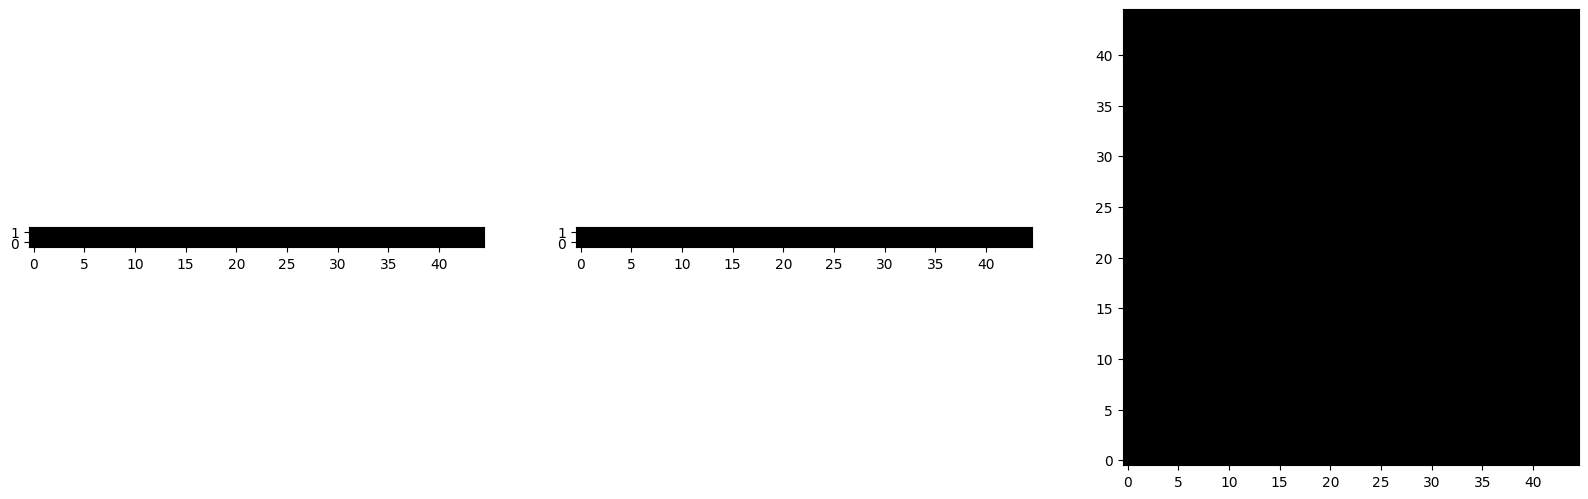

In [9]:
sim_mask=(iv+ov).bool()
SACshow(sim_mask[0,...],pad=False)

In [10]:
shape=(1,nx,ny,nz)
fov=torch.tensor([[24,24,24]]).to(device0)
phantom=SpinCube(shape,fov,mask=sim_mask,T1=460e-3,T2=60e-3,device=device0)

/home/yonglihe/miniconda3/envs/holisticMRI/lib/python3.11/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [11]:
beta=torch.tensor(np.linspace(0,90)).to(device0)
Mz=b2mz(beta,phantom)*torch.cos(torch.deg2rad(beta)) #Mz right before alpha excitation
Mz_hp=b2mz(torch.tensor([0]).to(device0),phantom) #Mz right before alpha when beta=0

weight=Mz/Mz_hp #the weighting over ref image due to tailored excitation

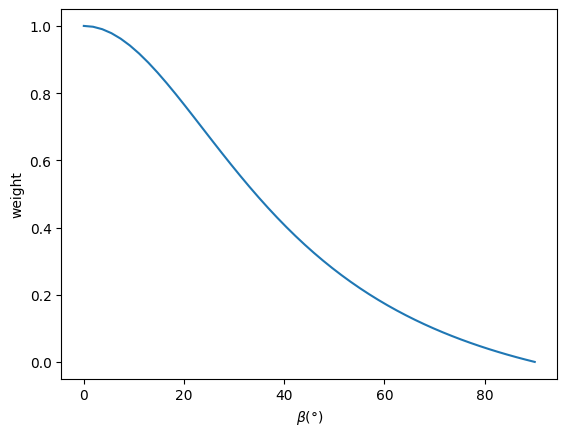

In [12]:
import matplotlib.pyplot as plt


plt.plot(beta.cpu(),weight.cpu())
plt.xlabel(r'$\beta(\degree)$')
plt.ylabel('weight')
plt.show()

In [51]:
pIni_path='../HolisticMRI/InitialPulse/pIni_OV90.npz'
pulse_npz=np.load(pIni_path)
rf=torch.tensor(pulse_npz['rf']).unsqueeze(0).to(device0)
gr=torch.tensor(pulse_npz['gr']).unsqueeze(0).to(device0)
gr[0,2,:]=0

pIni=Pulse(rf=rf,gr=gr,rfmax=rfmax0,gmax=gmax0,smax=torch.tensor(15e3).to(device0),dt=dt0,device=device0)

In [14]:
target_ss=Target_SS(phantom,iv.squeeze(0),ov.squeeze(0),beta_iv=0,beta_ov=90,alpha=20, T_r=80e-3-pIni.dt*pIni.rf.shape[-1],device=device0,weight_iv=0.1,weight_ov=0.9)

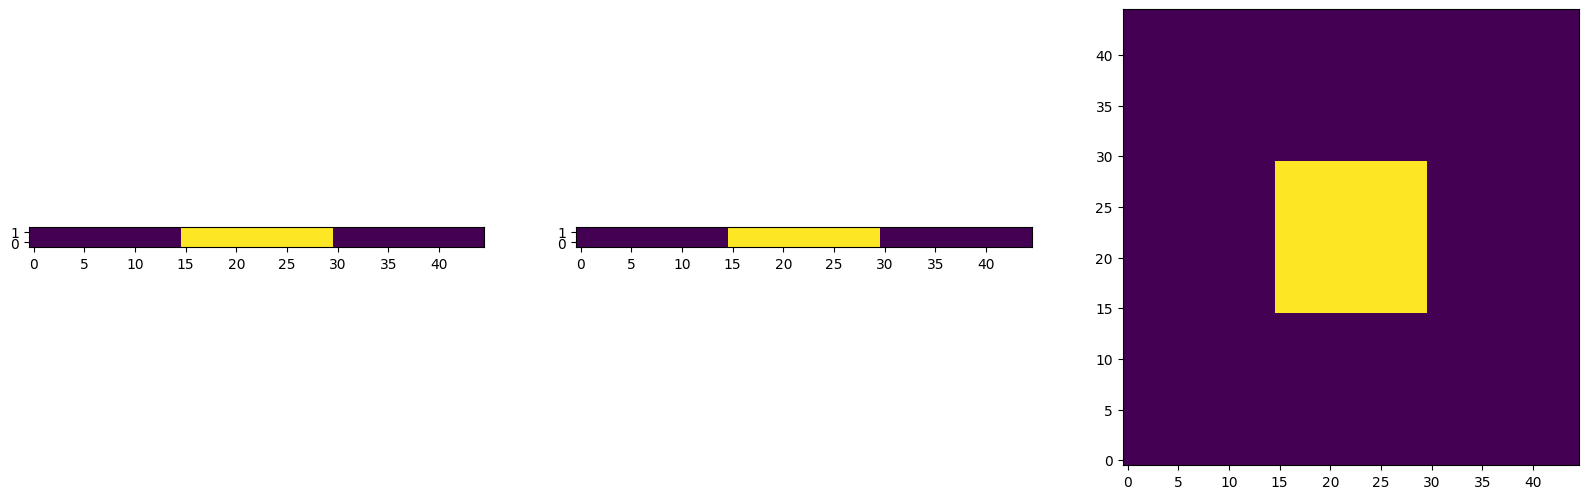

In [16]:
SACshow(target_ss['d'][0,...,2],cmap='viridis',pad=False)

In [18]:
target_ss['d'][0,23,:,1,2].unique()

tensor([-6.4727e-09,  7.4241e-01], device='cuda:0')

In [19]:
phantom.T1.unique()

tensor([0.4600], device='cuda:0')

In [20]:
target_ss_={
    'd_':phantom.extract(target_ss['d']),
    'weight_':phantom.extract(target_ss['weight'])
}

In [46]:
#pIni=6ms alpha=20, TR=80ms
[pAD,optInfo]=optimizers_ss.arctanLBFGS(target_ss_,phantom,pIni,sms=False, niter=4,alpha=20, TR=80e-3, fn_err=metrics.err_l2z,fn_pen=penalties.pen_l2)

0	 | 0.000	 | 1.612e+02	 | 1.030e+00	 | 1.654e+02	 | 4.083e-02

#iter	 ‖ elapsed time	 ‖ error	 ‖ penalty	 ‖ total loss	 ‖ avg loss
rf-loop:  2
1	 | 6.770	 | 5.817e+00	 | 4.359e+00	 | 2.326e+01	 | 5.742e-03
1	 | 13.650	 | 5.053e+00	 | 2.775e+00	 | 1.615e+01	 | 3.989e-03
gr-loop:  2
1	 | 39.746	 | 4.401e+00	 | 2.775e+00	 | 1.550e+01	 | 3.828e-03
1	 | 65.387	 | 4.144e+00	 | 2.775e+00	 | 1.525e+01	 | 3.764e-03
rf-loop:  2
2	 | 71.663	 | 4.038e+00	 | 2.366e+00	 | 1.350e+01	 | 3.334e-03
2	 | 77.937	 | 3.981e+00	 | 2.192e+00	 | 1.275e+01	 | 3.148e-03
gr-loop:  2
2	 | 104.278	 | 3.690e+00	 | 2.192e+00	 | 1.246e+01	 | 3.076e-03
2	 | 130.038	 | 3.581e+00	 | 2.192e+00	 | 1.235e+01	 | 3.049e-03
rf-loop:  2
3	 | 136.805	 | 3.615e+00	 | 2.038e+00	 | 1.177e+01	 | 2.906e-03
3	 | 143.603	 | 3.528e+00	 | 1.979e+00	 | 1.144e+01	 | 2.825e-03
gr-loop:  2
3	 | 169.686	 | 3.233e+00	 | 1.979e+00	 | 1.115e+01	 | 2.753e-03
3	 | 195.826	 | 3.125e+00	 | 1.979e+00	 | 1.104e+01	 | 2.726e-03
rf-loop:  2
4	 | 202.58

In [47]:
def saveAD(pAD,optInfo,filename):
    '''save the optimized pulse and loss history
    '''
    data={
        'rf':pAD.rf.cpu().numpy(),
        'gr':pAD.gr.cpu().numpy(),
        'time':optInfo['time_hist'],
        'loss':optInfo['loss_hist']
        #'optInfo':optInfo
    }
    ext=os.path.splitext(filename)[1]
    print(ext)
    if ext=='.h5':
        with h5py.File(filename,'w') as file:
            for key,value in data.items():
                file.create_dataset(key,data=value)
    elif ext=='.mat':
        scipy.io.savemat(filename,data)
    elif ext=='.npz':
        np.savez(filename,rf=data['rf'],gr=data['gr'],time=data['time'],loss=data['loss'])
    return

In [54]:
saveAD(pAD,optInfo,'pAD-EXT-guide-PHANTOM-TR80ms-2D.npz')

.npz


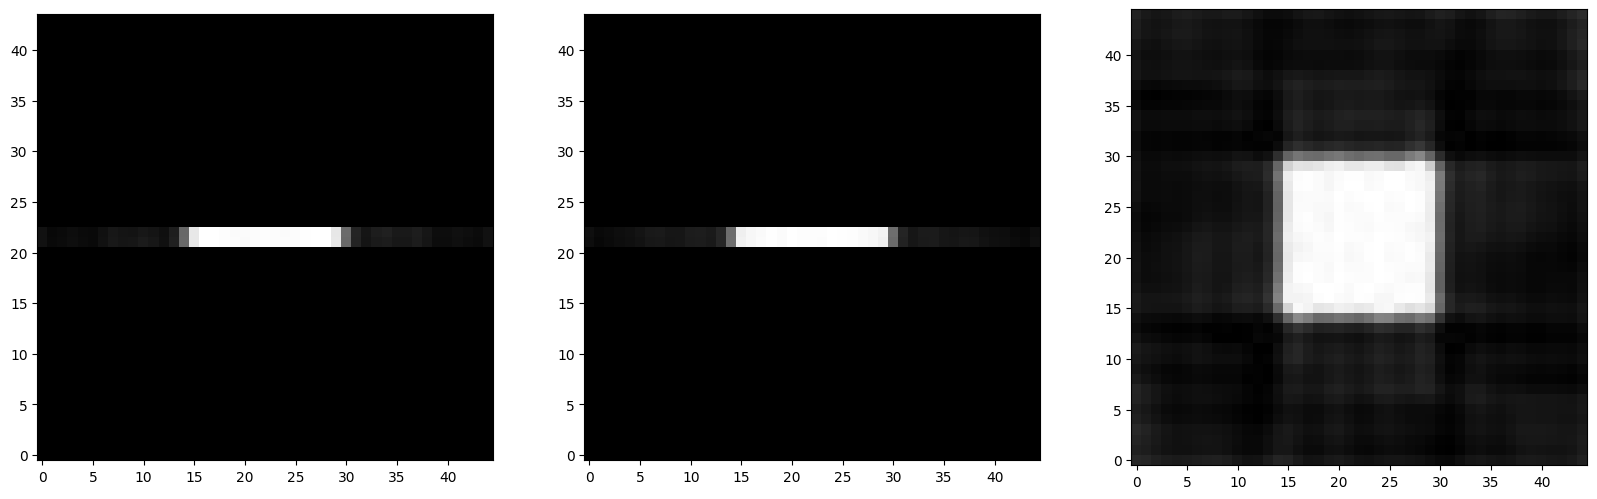

In [49]:
Mss=phantom.applypulse_ss(pAD,doEmbed=True,TR=80e-3,alpha=20)
SACshow(Mss.squeeze(0)[...,2].cpu())

In [24]:
Mss[0,23,20,:,2]

tensor([0.8100, 0.8210], device='cuda:0')

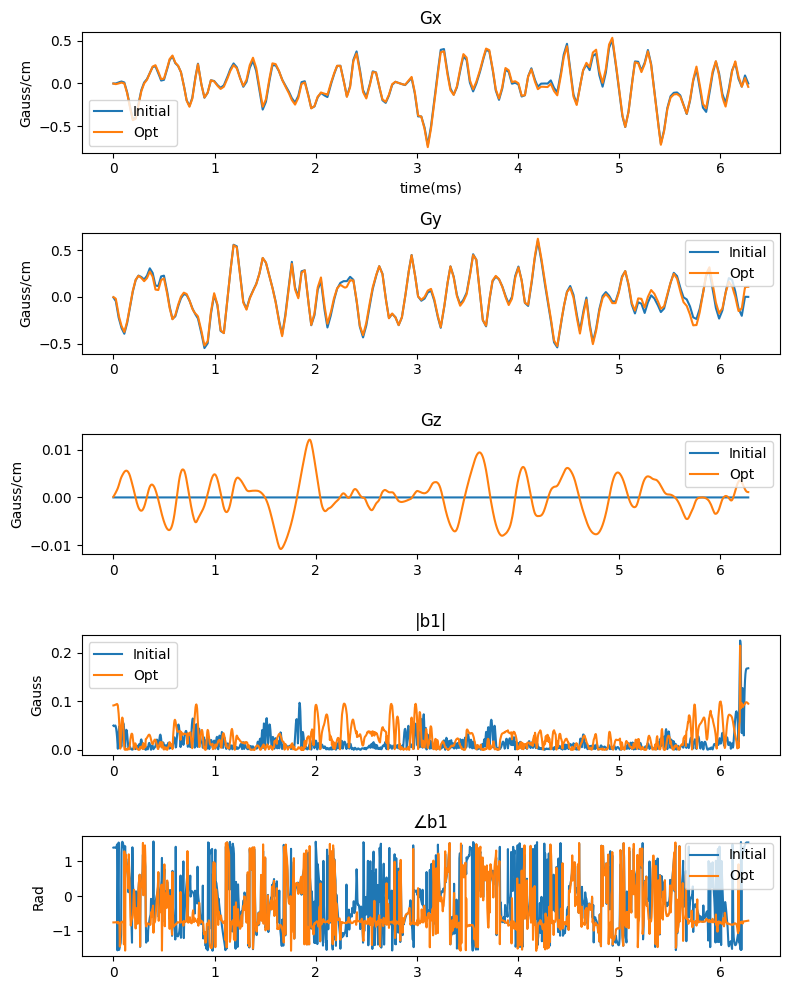

In [52]:
#[gx,gy,gz,rf_mag,rf_phase]=pulse2np(pAD)
#plot_seq(pAD)

#[gx2,gy2,gz2,rf_mag2,rf_phase2]=pulse2np(pIni)
#plot_seq(pIni)
compare_pulses([pIni,pAD],['Initial','Opt'])

In [29]:
# pAD_npz=np.load('./pAD-EXT-guide-sub001.npz')
# rf_opt=pAD_npz

In [21]:
Mss=phantom.applypulse_ss(pAD,doEmbed=True,alpha=20,TR=80e-3)
#Mss_ini=phantom.applypulse_ss(pIni,doEmbed=True,alpha=20)

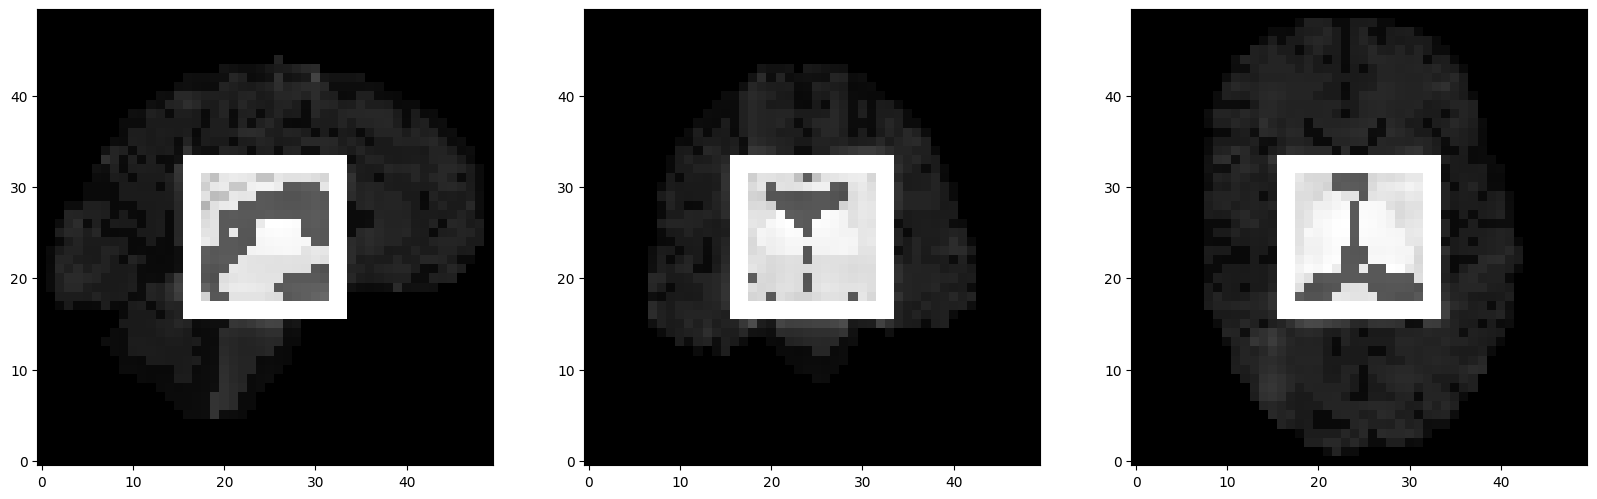

In [22]:
SACshow(Mss[0,...,2].cpu().numpy())

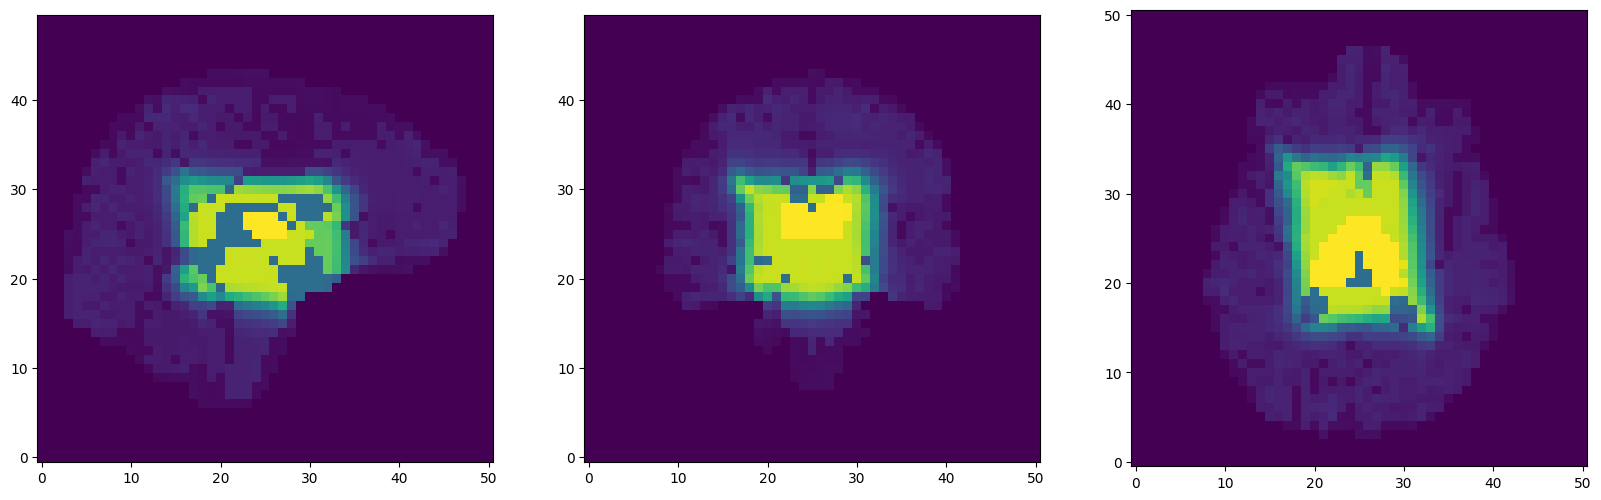

In [33]:
SACshow(Mss_ini[0,...,2].cpu().numpy(),cmap='viridis')